# Explore spatial averaging on horizontal yagi antenna

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 15/8/2022

+ FEKO data provided by Danie Ludick
+ Uses **v11** RFcalcUC module
+ This notebook uses dataframes in HDF5 files that were generated from the `make_HDF5_MBS_panel_trial2.ipynb` notebook

## Load necessary python modules

In [1]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

## Look at model metadata for the spatial averaging trials

In [2]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2,3,4,5,6,7,8
INPUT,,,,,,,,,
fMHz,MHz,900,900,900,70,180,400,700,1000
antenna,,IEC 62232 panel antenna,IEC 62232 panel antenna,Yagi,Omni,Omni,Omni,Omni,Omni
Prad,W,80,200,100,100,100,100,100,100
dBiGain,,,,,7.37,7.38,7.38,7.38,7.38
horizHPBW,deg,,,,360,360,360,360,360
vertHPBW,deg,,,,20.3,20.3,20.3,20.3,20.3
coordinate_origin,,centre of the middle feed segment,centre of the middle feed segment,centre of rear reflector,centre of omni,centre of omni,centre of omni,centre of omni,centre of omni
xstart,m,0.5,-1,-1,0.05,0.05,0.05,0.05,0.05
xend,m,14,14,5,5.05,5.05,5.05,5.05,5.05


## Create the RFc object for the analyses
The class for this object is in the `RFcalcUC_v11.py` file

In [3]:
# Set trial number
trial = 3
t = trials[str(trial)]

In [4]:
# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 100 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [0, 0.48]
yb = [-0.1, 0.1]
zb = [-0.05, 0.05]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)
R

datadir = '../antennas/Hyagi/data/'
plotdir = '../antennas/Hyagi/plots/'


Object parameters:
  900 MHz, 100 W
  errtol = 0.15
  offset = 0 m
  default length of spatial averagering window = 1.6 m
  152,561 grid points
  nx = 61, ny = 41, nz = 61

In [5]:
# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print(*R.grid.items(),sep='\n')

Sfile='../antennas/Hyagi/data/Hyagi.hdf5'


,x,y,z,r,phi,SE,SH,Smax,SARwbi
0,-1.0,-2.0,-3.0,2.236068,-116.565051,0.161726,0.161659,0.161726,NaN
1,-1.0,-2.0,-2.9,2.236068,-116.565051,0.165805,0.165718,0.165805,NaN
2,-1.0,-2.0,-2.8,2.236068,-116.565051,0.169610,0.169503,0.169610,NaN
3,-1.0,-2.0,-2.7,2.236068,-116.565051,0.173072,0.172948,0.173072,NaN
4,-1.0,-2.0,-2.6,2.236068,-116.565051,0.176124,0.175984,0.176124,NaN


{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}

('x', [-1, 5, 0.1])
('y', [-2, 2, 0.1])
('z', [-3, 3, 0.1])


In [6]:
# Create filters for valid 1.6m and 2m spatial averaging points
fsa16 = R.sf('spatavg', spatavgL=1.6) # valid 1.6m spatial averaging points
fsa20 = R.sf('spatavg', spatavgL=2.0) # valid 2.0m spatial averaging points
fsa06 = R.sf('spatavg', spatavgL=0.6) # valid 0.6m spatial averaging points
foutant = R.sf('outant', offset=0)    # all points outside antenna box

# Show invalid points for 1.6m spatial aveargaing, i.e. where 1.6m body intersects antenna
# RFcalcUC.show_grid_points(R.S[~fsa16.mask], fields=['SE'],hman=None,axv=(False,False,False),
#                           antcolor='yellow',bgcolor='white',antenna=RFcalcUC.hyagi,title='0.2m outant')

## Data checks

In [7]:
# Display the horizontal antenna
fig = mlab.figure(1, size=(1200,900), 
                  bgcolor=(1,1,1),
                  fgcolor=(0,0,0))
mlab.clf()
RFcalcUC.vyagi('yellow')

# draw the axes
ax = mlab.axes(x_axis_visibility=False, y_axis_visibility=False, z_axis_visibility=False,
               color=(0,0,0))

# Draw the scene
fig.scene.parallel_projection = True
mlab.show()

### Show S and SAR grids

In [8]:
R.S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152561 entries, 0 to 152560
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       152561 non-null  float64
 1   y       152561 non-null  float64
 2   z       152561 non-null  float64
 3   r       152561 non-null  float64
 4   phi     152561 non-null  float64
 5   SE      152561 non-null  float64
 6   SH      152561 non-null  float64
 7   Smax    152561 non-null  float64
 8   SARwbi  102541 non-null  float64
dtypes: float64(9)
memory usage: 10.5 MB


### View public and occ compliance zones

In [9]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.ExclusionZone(
    data=["SE", "SE"],
    power=[100, 100],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="RPS S-1 public and occupational exclusion zones for FEKO SE data",
    figsize=(1200,800),
    antenna=RFcalcUC.hyagi,
    axv=[True,False,True]
)

dat='SE', con=4.5
dat='SE', con=22.5
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=100, setting=occupational, limit=22.5 W/m², contour level=22.500


In [10]:
# Animated 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.AnimatedExclusionZone(
    data=["SE", "SE"],
    power=[50, 50],
    color=["gold", "red"],
    alpha=[0.5, 0.5],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    ycut=0,
    daz=-0.1,
    elevation = 80,
    distance=None,
    title="",
    figsize=(1200,800),
    antenna=RFcalcUC.hyagi,
    axv=[False,False,False]
)

dat='SE', con=9.0
dat='SE', con=45.0
power=100, plotpower=50, setting=public, limit=4.5 W/m², contour level=9.000
power=100, plotpower=50, setting=occupational, limit=22.5 W/m², contour level=45.000


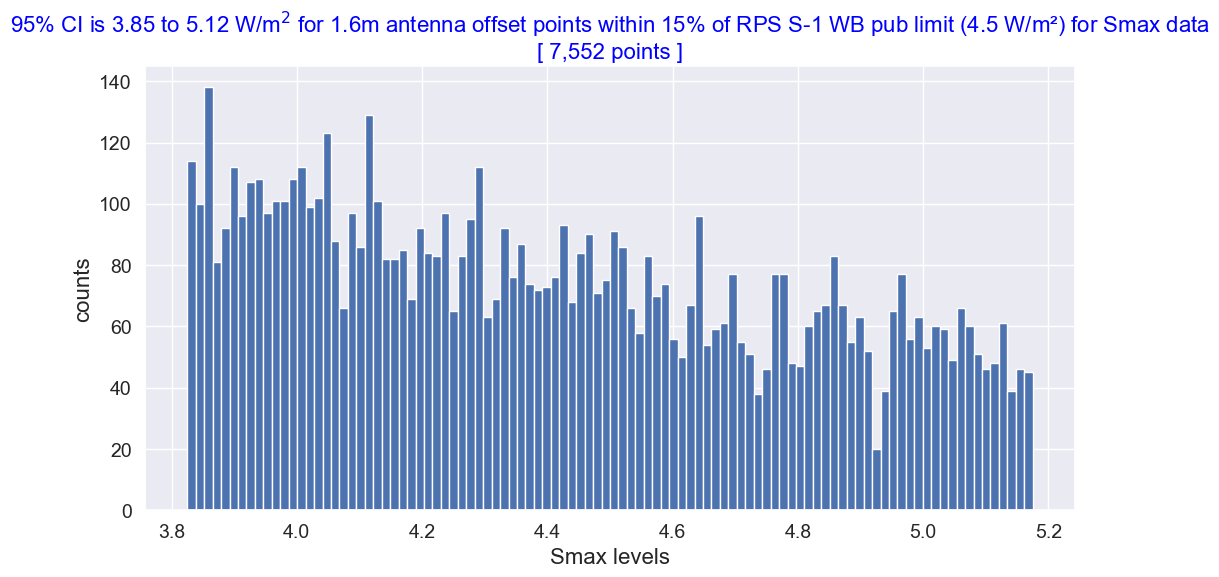

In [11]:
# Show SARwbi histogram
f = fsa16
f = R.sf('cb', offset=1.6, setting='pub')
R.hist(data='Smax', f=f, bins=100)

## Create spatially averaged fields
Create some new S columns for vertical spatial averaging

**c** is the convolution vector applied to z columns of points for each (x,y) group

In [12]:
def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

In [13]:
# 1.6m vertical average curves
l, dl = 1.6, 0.1
for m in [17,5,3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


17 points: sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0
creating SE-1.6m-17 spatial average of SE
creating Smax-1.6m-17 spatial average of Smax

 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
creating SE-1.6m-5 spatial average of SE
creating Smax-1.6m-5 spatial average of Smax

 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-1.6m-3 spatial average of SE
creating Smax-1.6m-3 spatial average of Smax


In [14]:
# 1.6m vertical average curves using Simpsons 1/3 rule
l = 1.6
c17 = [1,4,2,4,2,4,2,4,2,4,2,4,2,4,2,4,1]
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
c3  = [1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1]
for m,clist in zip([3,5,17],[c3,c5,c17]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}-S13", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 1/3))")
    R.spatavg(f"Smax-{l}m-{m}-S13", "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 1/3))")


 3 points: sum[0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167] = 0.9999999999999999
creating SE-1.6m-3-S13 spatial average of SE
creating Smax-1.6m-3-S13 spatial average of Smax

 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SE-1.6m-5-S13 spatial average of SE
creating Smax-1.6m-5-S13 spatial average of Smax

17 points: sum[0.021, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.021] = 1.0
creating SE-1.6m-17-S13 spatial average of SE
creating Smax-1.6m-17-S13 spatial average of Smax


In [15]:
# 2m vertical average curves
l, dl = 2, 0.1
for m in [3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-2m-3 spatial average of SE
creating Smax-2m-3 spatial average of Smax


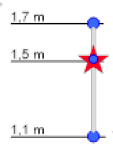

In [16]:
# IEC 62232 spatial averaging scheme (3pts over 0.6m)
c = np.array([1,0,0,0,1,0,1,0,0]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-0.6m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 0.6m)")
R.spatavg(f"Smax-IEC-0.6m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 0.6m)")

len(c) = 9 points: sum[0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333, 0.0, 0.0] = 1.0
creating SE-IEC-0.6m-3 spatial average of SE
creating Smax-IEC-0.6m-3 spatial average of Smax


In [17]:
R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.6m-3-S13': 'FEKO SE levels (3 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-3-S13': 'FEKO Smax levels (3 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-5-S13': 'FEKO SE levels (5 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-5-S13': 'FEKO Smax levels (5 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-17-S13': 'FEKO SE levels (17 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-17-S13': 'FEKO Smax levels (17 poi

## Compare compliance zones

R essentially indicates the level of over-estimating WBA SAR compliance when conforming with the S limits. R ≥ 1 at an assessment point implies that WBA SAR will be compliant if S is compliant at that point and so it is desirable that R is always greater than or equal to 1.

#### Animated SAR vs 1.6m pt compliance zones

In [18]:
# Animated 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.AnimatedExclusionZone(
    data=["SARwbi", "Smax-1.6m-5"],
    power=[100, 100],
    color=["magenta", "green"],
    alpha=[0.5, 0.5],
    setting=["public", "public"],
    standard=["RPS S-1 WB"] * 2,
    ycut=0,
    daz=-0.1,
    elevation = 80,
    distance=None,
    title="",
    figsize=(1200,800),
    antenna=RFcalcUC.hyagi,
    axv=[False,False,False]
)

dat='SARwbi', con=0.08
dat='Smax-1.6m-5', con=4.5
power=100, plotpower=100, setting=public, limit=0.08 W/kg, contour level=0.080
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500


#### WBA SAR vs all S settings

In [19]:
# Compare SAR, Smax
n = 6
R.ExclusionZone(
    data=["SARwbi","Smax","Smax-1.6m-17","Smax-1.6m-5","Smax-1.6m-3","Smax-IEC-0.6m-3"],
    power=[80] * n,
    color=["magenta","lightgrey","green","blue","brown","olive"],
    alpha=[1,0.5,0.5,0.5,0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs S compliance zones",
    ycut=0,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax', con=5.625
dat='Smax-1.6m-17', con=5.625
dat='Smax-1.6m-5', con=5.625
dat='Smax-1.6m-3', con=5.625
dat='Smax-IEC-0.6m-3', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs peak spatial Smax

In [19]:
# Compare SAR, Smax
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax"],
    power=[80] * n,
    color=["magenta","lightgrey"],
    alpha=[0.7, 0.7],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### SE spatial average 2m over 3pts

In [32]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["Smax-2m-3","Smax-2m-3"],
    power=[200]*2,
    color=["yellow","red"],
    alpha=[0.5]*2,
    setting=["public","occ"],
    standard=["RPS S-1 WB"]*2,
    title="SE-2m-3 public and occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=4.5
dat='Smax-2m-3', con=22.5
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500
power=200, plotpower=200, setting=occ, limit=22.5 W/m², contour level=22.500


In [33]:
# Compare SAR, Ssa 1.6m 17pts
n = 1
R.ExclusionZone(
    data=["Smax-2m-3"],
    power=[200],
    color=["red"],
    alpha=[0.5],
    setting=["occ"],
    standard=["RPS S-1 WB"],
    title="SE-2m-3 occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=22.5
power=200, plotpower=200, setting=occ, limit=22.5 W/m², contour level=22.500


#### WBA SAR vs Smax spatial average 1.6m over 17pts

In [24]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.7, 0.7],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-17 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-17', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs Smax spatial average 1.6m over 5pts

In [36]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-5', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


In [27]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
n = 2
R.AnimatedExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.3],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    ycut=0,
    daz=-0.2,
    elevation = 60,
    distance=None,
    title="",
    showtitle=False,
    figsize=(900,900),
    antenna=RFcalcUC.hyagi,
    axv=[False,False,False],
    bg='lightgrey',
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-5', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs Smax spatial average 1.6m over 3pts

In [34]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-3', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs SE spatial average 1.6m over 5pts

In [38]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","SE-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs SE-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='SE-1.6m-5', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs Smax IEC spatial average 0.6m over 3pts

In [40]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-IEC-0.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.1
dat='Smax-IEC-0.6m-3', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs SE-1.6m-5 and SE-1.6m-5-S13

In [15]:
# Compare SAR, SEsa 1.6m 5pts
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5","Smax-1.6m-5-S13"],
    power=[40] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5', con=11.25
dat='Smax-1.6m-5-S13', con=11.25
power=100, plotpower=40, setting=public, limit=0.08 W/kg, contour level=0.200
power=100, plotpower=40, setting=public, limit=4.5 W/m², contour level=11.250
power=100, plotpower=40, setting=public, limit=4.5 W/m², contour level=11.250


## Compliance ratio for SARwbi

### Generate compliance ratio statistic, R
$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}\; \; \; \; \; \; \; (Eq. 1)$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

In [20]:
# Limits at 900 MHz
Slim = 4.5
SARlim = 0.08

# Create list of fields and associated filters for R ratios
Slist = ['Smax',  'Smax-1.6m-17','Smax-1.6m-5','Smax-1.6m-3','SE-1.6m-5','Smax-IEC-0.6m-3']
flist = [foutant, fsa16,         fsa16,        fsa16,        fsa16,      fsa06]

# Create S columns for R ratios
for Si in Slist:
    cr = (R.S[Si]/Slim) / (R.S.SARwbi/SARlim) 
    crname = f'{Si} SARwbi compliance ratio' 
    R.addS(cr, crname, f'Ratio of {Si} compliance to SARwbi compliance')

    dBcr = 10. * np.log10((R.S[Si]/Slim) / (R.S.SARwbi/SARlim))
    dBcrname = f'dB {Si} SARwbi compliance ratio' 
    R.addS(dBcr, dBcrname, f'dB Ratio of {Si} compliance to SARwbi compliance')

# Create list of Slist column names for compliance ratios 
dtlist =   [dt for scol in Slist for dt in R.datatitles if scol+' ' in dt and 'compliance' in dt and 'dB' not in dt]
dtdBlist = [dt for scol in Slist for dt in R.datatitles if scol+' ' in dt and 'compliance' in dt and 'dB' in dt]

In [21]:
R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.6m-3-S13': 'FEKO SE levels (3 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-3-S13': 'FEKO Smax levels (3 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-5-S13': 'FEKO SE levels (5 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-5-S13': 'FEKO Smax levels (5 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-17-S13': 'FEKO SE levels (17 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-17-S13': 'FEKO Smax levels (17 poi

### R histograms

#### R histogram function

In [22]:
# Function to draw histograms of limit normalised ratios of Smax vs WBA SAR
def histR(Slist,dtlist,flist,cols=2):
    nS = len(dtlist)
    rows = int(np.ceil(nS/cols))
    dB = True if 'dB' in dtlist[0] else False 
    
    if dB:
        xlabel = 'dB(R)'
        cisuffix = ' dB'
        bins = np.linspace(-3,6,51)
    else:
        xlabel = 'R'
        cisuffix = ''
        bins = np.linspace(0,6,51)
        
    fig, axes = plt.subplots(rows,cols,figsize=(10,14),sharey=True)
    axes = axes.flatten()

    for i, (s,dt,f) in enumerate(zip(Slist,dtlist,flist)):
        data = R.S.loc[f.mask,dt].dropna()
        axes[i].hist(data,bins=bins,density=True)
        axes[i].set_title(s, fontsize=15, color='g',fontweight="bold")
        axes[i].set_xlim(bins[0],bins[-1])
        ci = np.percentile(data,[2.5,97.5]).round(2)
        mean = data.mean().round(2)
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}\n$\\mu$ = {mean}{cisuffix}' 
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}' 
        if i % 2 == 0:
            axes[i].set_ylabel('normalised counts',fontsize=14)
        if dB:
            axes[i].axvline(x=0, color='r',ls='--')
            axes[i].text(0.04, 0.9, text, horizontalalignment='left',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            axes[i].text(0.04, 0.82, tr.fill(f.name,width=25), horizontalalignment='left',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=14, color='b')
        else:
            axes[i].axvline(x=1, color='r',ls='--')
            axes[i].text(0.96, 0.9, text, horizontalalignment='right',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            axes[i].text(0.96, 0.84, tr.fill(f.name,width=25), horizontalalignment='right',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=14, color='b')

        axes[i].set_xlabel(xlabel, fontsize=14)

    # if nSa != rows * cols: axes[-1].remove()
    title = 'Limit normalised ratios of S vs WBA SAR:  $R = \\frac{S/S_{lim}}{SAR/SAR_{lim}}$\n'
    fig.suptitle(title, fontsize=20)
    fig.tight_layout(h_pad=1)
    
def showstats(dtlist,flist):
    table = []
    for (dt,f) in zip(dtlist,flist):
        data = R.S.loc[f.mask,dt].dropna()
        count = len(data)
        ci = np.percentile(data,[2.5,50,97.5]).round(2)
        mean = data.mean().round(2)
        std = data.std().round(2)
        minval = data.min().round(2)
        maxval = data.max().round(2)
        table.append([dt,count,mean,std,minval,ci[0],ci[1],ci[2],maxval])
    df = pd.DataFrame(table,columns=('data','count','mean','std','min','2.5%','50%','97.5%','max'))
    
    return df.set_index('data')

#### R histograms

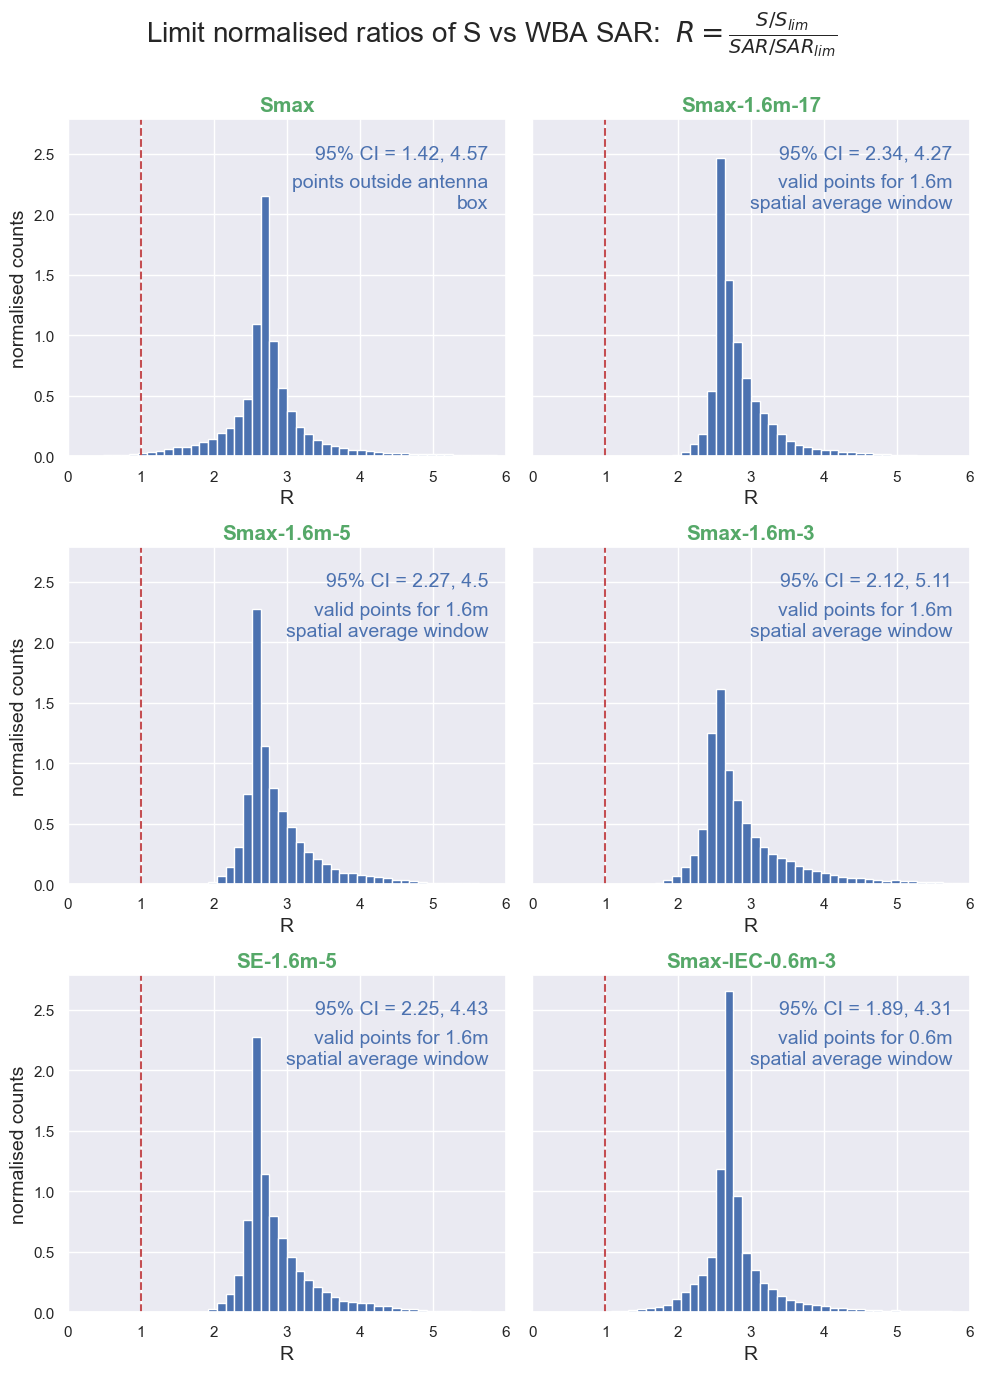

In [23]:
# R histograms for Slist
histR(Slist,dtlist,flist,cols=2)
plt.savefig(plotdir + 'R histogram yagi.png', dpi=150)

In [24]:
showstats(dtlist,flist)

,count,mean,std,min,2.5%,50%,97.5%,max
data,,,,,,,,
Smax SARwbi compliance ratio,102526,2.77,1.35,0.24,1.42,2.71,4.57,226.34
Smax-1.6m-17 SARwbi compliance ratio,102286,2.86,0.53,1.17,2.34,2.70,4.27,37.52
Smax-1.6m-5 SARwbi compliance ratio,102286,2.90,0.77,1.58,2.27,2.70,4.50,92.24
Smax-1.6m-3 SARwbi compliance ratio,102286,2.95,1.13,0.53,2.12,2.68,5.11,148.93
SE-1.6m-5 SARwbi compliance ratio,102286,2.88,0.63,0.90,2.25,2.70,4.43,39.55
Smax-IEC-0.6m-3 SARwbi compliance ratio,102436,2.82,4.45,0.32,1.89,2.69,4.31,1356.30


In [25]:
R.S.columns

Index(['x', 'y', 'z', 'r', 'phi', 'SE', 'SH', 'Smax', 'SARwbi', 'SE-1.6m-17',
       'Smax-1.6m-17', 'SE-1.6m-5', 'Smax-1.6m-5', 'SE-1.6m-3', 'Smax-1.6m-3',
       'SE-1.6m-3-S13', 'Smax-1.6m-3-S13', 'SE-1.6m-5-S13', 'Smax-1.6m-5-S13',
       'SE-1.6m-17-S13', 'Smax-1.6m-17-S13', 'SE-2m-3', 'Smax-2m-3',
       'SE-IEC-0.6m-3', 'Smax-IEC-0.6m-3', 'Smax SARwbi compliance ratio',
       'dB Smax SARwbi compliance ratio',
       'Smax-1.6m-17 SARwbi compliance ratio',
       'dB Smax-1.6m-17 SARwbi compliance ratio',
       'Smax-1.6m-5 SARwbi compliance ratio',
       'dB Smax-1.6m-5 SARwbi compliance ratio',
       'Smax-1.6m-3 SARwbi compliance ratio',
       'dB Smax-1.6m-3 SARwbi compliance ratio',
       'SE-1.6m-5 SARwbi compliance ratio',
       'dB SE-1.6m-5 SARwbi compliance ratio',
       'Smax-IEC-0.6m-3 SARwbi compliance ratio',
       'dB Smax-IEC-0.6m-3 SARwbi compliance ratio'],
      dtype='object')

In [26]:
# Get proportion of R < 1 values for Smax 
SmaxR = R.S['Smax SARwbi compliance ratio'].dropna()
nall = len(SmaxR)              # count of all not null R values
nlowR = len(SmaxR[SmaxR < 1])  # count of R values < 1
nlowR / nall

0.0076164656088784

#### dB(R) histograms

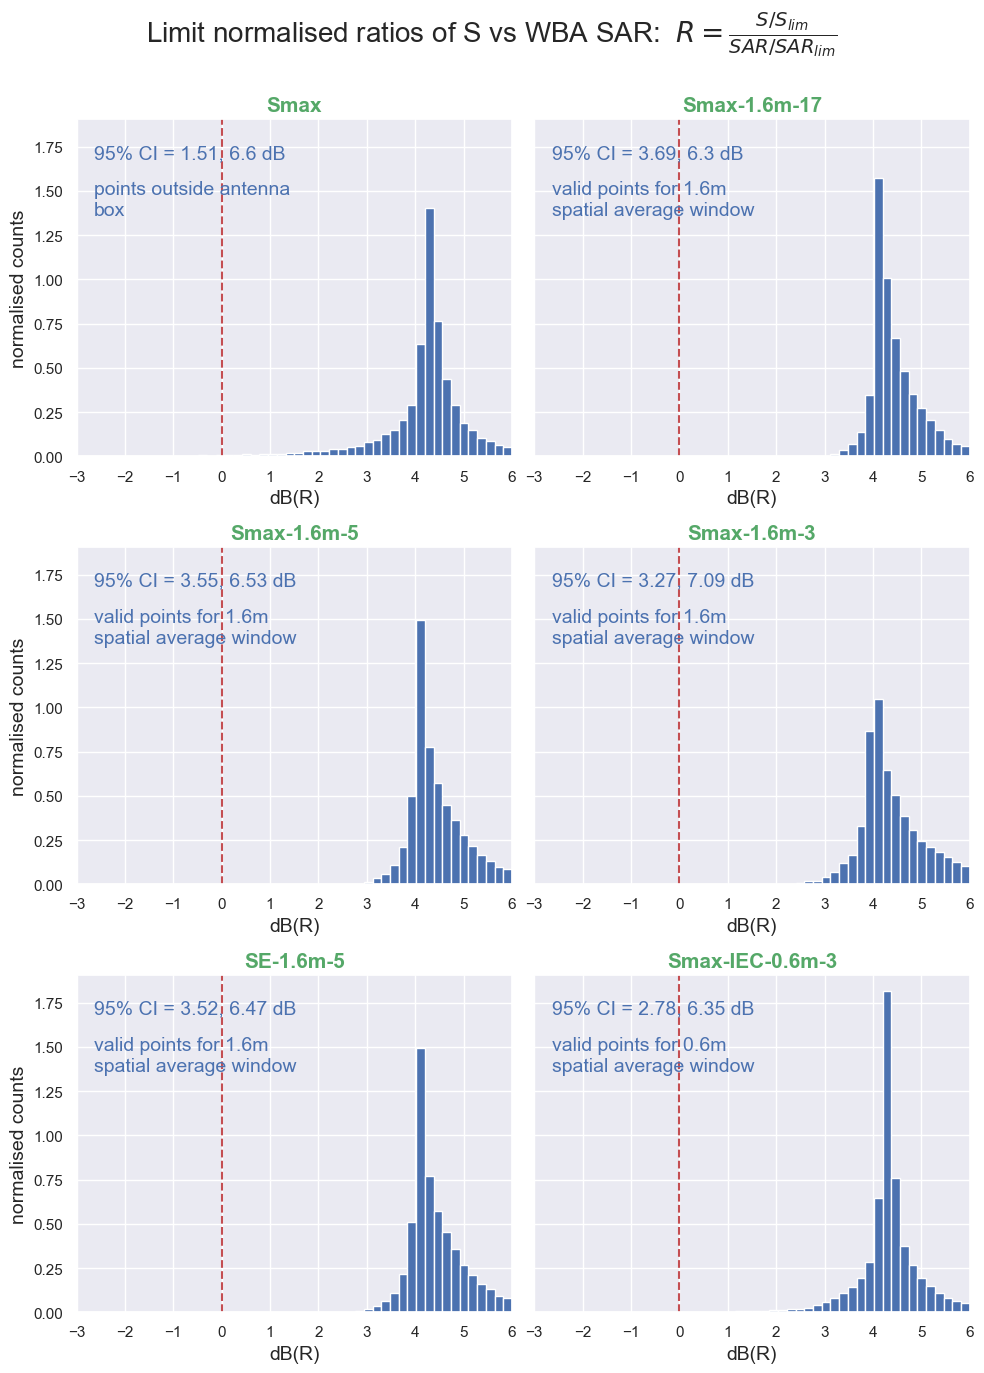

In [27]:
# dB(R) histograms for Slist
histR(Slist,dtdBlist,flist,cols=2)
plt.savefig(plotdir + 'dB(R) histogram yagi.png', dpi=150)

In [22]:
showstats(dtdBlist,flist)

,count,mean,std,min,2.5%,50%,97.5%,max
data,,,,,,,,
dB Smax SARwbi compliance ratio,102526,4.28,1.13,-6.21,1.51,4.32,6.60,23.54
dB Smax-1.6m-17 SARwbi compliance ratio,102286,4.51,0.64,0.69,3.69,4.32,6.30,15.74
dB Smax-1.6m-5 SARwbi compliance ratio,102286,4.55,0.76,1.98,3.55,4.31,6.53,19.65
dB Smax-1.6m-3 SARwbi compliance ratio,102286,4.57,0.97,-2.76,3.27,4.29,7.09,21.73
dB SE-1.6m-5 SARwbi compliance ratio,102286,4.52,0.74,-0.47,3.52,4.30,6.47,15.97
dB Smax-IEC-0.6m-3 SARwbi compliance ratio,102436,4.38,0.84,-4.99,2.78,4.30,6.35,31.34


#### R histograms with outant box filter
distance offset of $2\lambda$ from surface of antenna box

wavelength = 0.333m


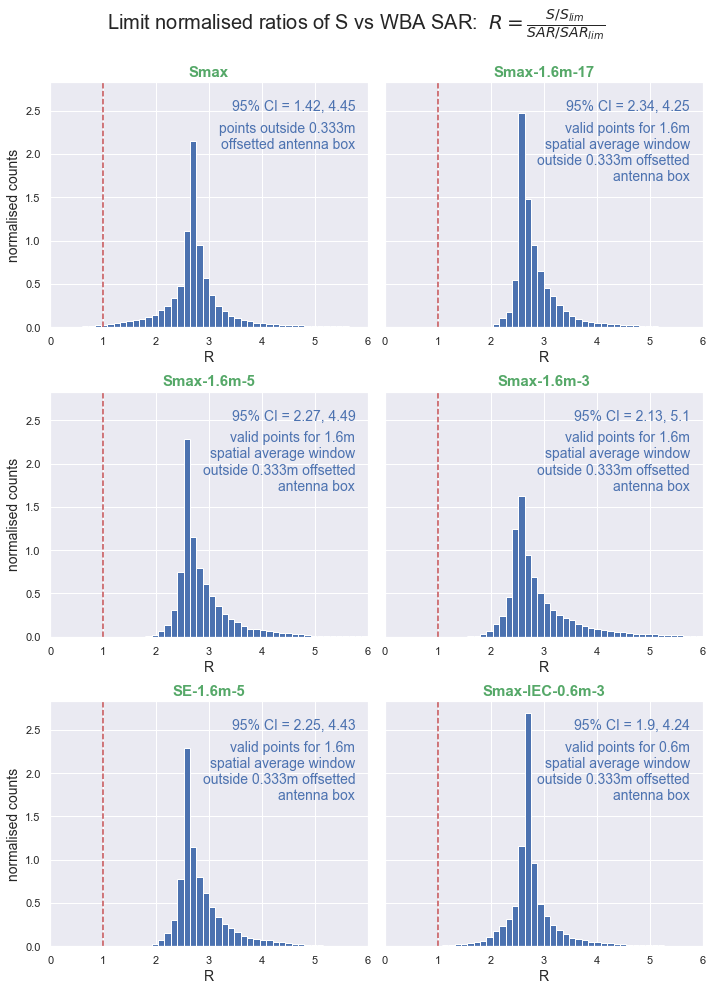

In [52]:
# R histograms for Slist with outant box filter 0.1m from antenna surface
wv = round(300 / t.fMHz,3)  # one wavelength
print(f'wavelength = {wv}m')

# Create filters with one wavelength outant
fsa16wv = R.sf('spatavg_outant',spatavgL=1.6,offset=wv) # valid 1.6m spatial averaging pts with one wavelength outant
fsa20wv = R.sf('spatavg_outant',spatavgL=2.0,offset=wv) # valid 2.0m spatial averaging pts with one wavelength outant
fsa06wv = R.sf('spatavg_outant',spatavgL=0.6,offset=wv) # valid 0.6m spatial averaging pts with one wavelength outant
foutantwv = R.sf('outant', offset=wv)    # all points one wavelength outside antenna box

# Create lists for filters and filter names
Slist =   ['Smax',    'Smax-1.6m-17','Smax-1.6m-5','Smax-1.6m-3','SE-1.6m-5','Smax-IEC-0.6m-3']
flistwv = [foutantwv, fsa16wv,       fsa16wv,      fsa16wv,      fsa16wv,    fsa06wv]

# Plot and save histograms
histR(Slist,dtlist,flistwv,cols=2)
plt.savefig(plotdir + 'R histogram one wavelength outant yagi.png', dpi=150)

In [49]:
showstats(dtlist,flistwv)

,count,mean,std,min,2.5%,50%,97.5%,max
data,,,,,,,,
Smax SARwbi compliance ratio,101785,2.75,0.67,0.24,1.42,2.70,4.45,16.74
Smax-1.6m-17 SARwbi compliance ratio,101635,2.86,0.52,1.17,2.34,2.70,4.25,37.51
Smax-1.6m-5 SARwbi compliance ratio,101635,2.90,0.76,1.58,2.27,2.70,4.49,92.22
Smax-1.6m-3 SARwbi compliance ratio,101635,2.95,1.12,0.53,2.13,2.68,5.10,148.89
SE-1.6m-5 SARwbi compliance ratio,101635,2.88,0.62,1.18,2.25,2.69,4.43,39.54
Smax-IEC-0.6m-3 SARwbi compliance ratio,101785,2.81,4.47,0.32,1.90,2.69,4.24,1360.63


#### dB R histograms with outant box filter
distance offset of $\lambda$ from surface of antenna box

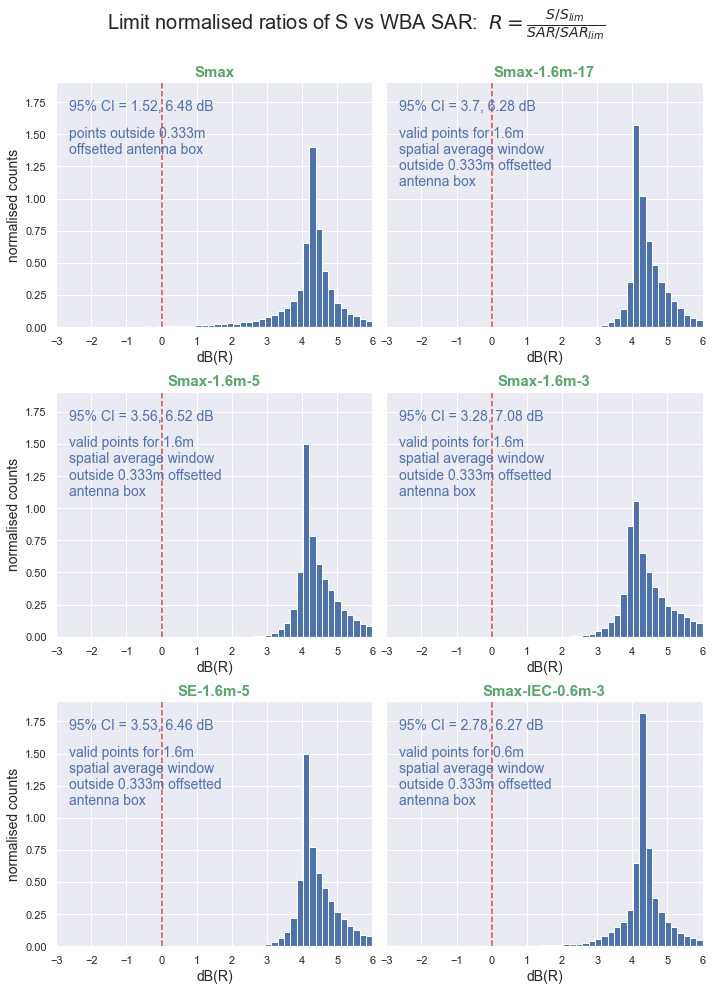

In [53]:
# dB(R) histograms for Slist
histR(Slist,dtdBlist,flistwv,cols=2)
plt.savefig(plotdir + 'dB(R) histogram one wavelength outant yagi.png', dpi=150)

In [51]:
showstats(dtdBlist,flistwv)

,count,mean,std,min,2.5%,50%,97.5%,max
data,,,,,,,,
dB Smax SARwbi compliance ratio,101785,4.26,1.09,-6.21,1.52,4.32,6.48,12.24
dB Smax-1.6m-17 SARwbi compliance ratio,101635,4.51,0.63,0.69,3.70,4.31,6.28,15.74
dB Smax-1.6m-5 SARwbi compliance ratio,101635,4.54,0.76,1.98,3.56,4.31,6.52,19.65
dB Smax-1.6m-3 SARwbi compliance ratio,101635,4.56,0.96,-2.76,3.28,4.29,7.08,21.73
dB SE-1.6m-5 SARwbi compliance ratio,101635,4.52,0.74,0.73,3.53,4.30,6.46,15.97
dB Smax-IEC-0.6m-3 SARwbi compliance ratio,101785,4.37,0.82,-4.99,2.78,4.30,6.27,31.34


#### Kolmogorov-Smirnov test for outant points

In [64]:
ks_table = R.S.loc[fsa16.mask,dtlist+dtdBlist].dropna().agg(stats.kstest, cdf='norm').T
ks_table.columns = ['KS statistic','p-value']
ks_table

,KS statistic,p-value
Smax SARwbi compliance ratio,0.910296,0.0
Smax-1.6m-17 SARwbi compliance ratio,0.979805,0.0
Smax-1.6m-5 SARwbi compliance ratio,0.976519,0.0
Smax-1.6m-3 SARwbi compliance ratio,0.966218,0.0
SE-1.6m-5 SARwbi compliance ratio,0.975386,0.0
Smax-IEC-0.6m-3 SARwbi compliance ratio,0.946438,0.0
dB Smax SARwbi compliance ratio,0.944368,0.0
dB Smax-1.6m-17 SARwbi compliance ratio,0.997958,0.0
dB Smax-1.6m-5 SARwbi compliance ratio,0.997402,0.0
dB Smax-1.6m-3 SARwbi compliance ratio,0.992117,0.0


<u>Notes</u>:

+ The p value signifies the likelihood of the null hypothesis, i.e. that the distribution is normal
+ The p values are 0 because of the very large number of points (1,298,751) in the distributions
+ the KS statistic shows that the **dB(R)** distributions for the 1.6m spatial averages of S are marginally more normal than the **R** distributions as their KS statistics are marginally higher. 

### R vs r

In [44]:
# Add a new r (r2) which measures distance from the centre of the yagi at x = 0.477/2 = 0.239m
R.S['r2'] = np.sqrt((R.S.x-0.2385)**2 + R.S.y**2 + R.S.z**2)
R.S[['x','y','z','r','r2']]

,x,y,z,r,r2
0,-1.0,-2.0,-3.0,2.236068,3.812333
1,-1.0,-2.0,-2.9,2.236068,3.734151
2,-1.0,-2.0,-2.8,2.236068,3.657032
3,-1.0,-2.0,-2.7,2.236068,3.581045
4,-1.0,-2.0,-2.6,2.236068,3.506263
...,...,...,...,...,...
152556,5.0,2.0,2.6,5.385165,5.782031
152557,5.0,2.0,2.7,5.385165,5.827682
152558,5.0,2.0,2.8,5.385165,5.874681
152559,5.0,2.0,2.9,5.385165,5.922996


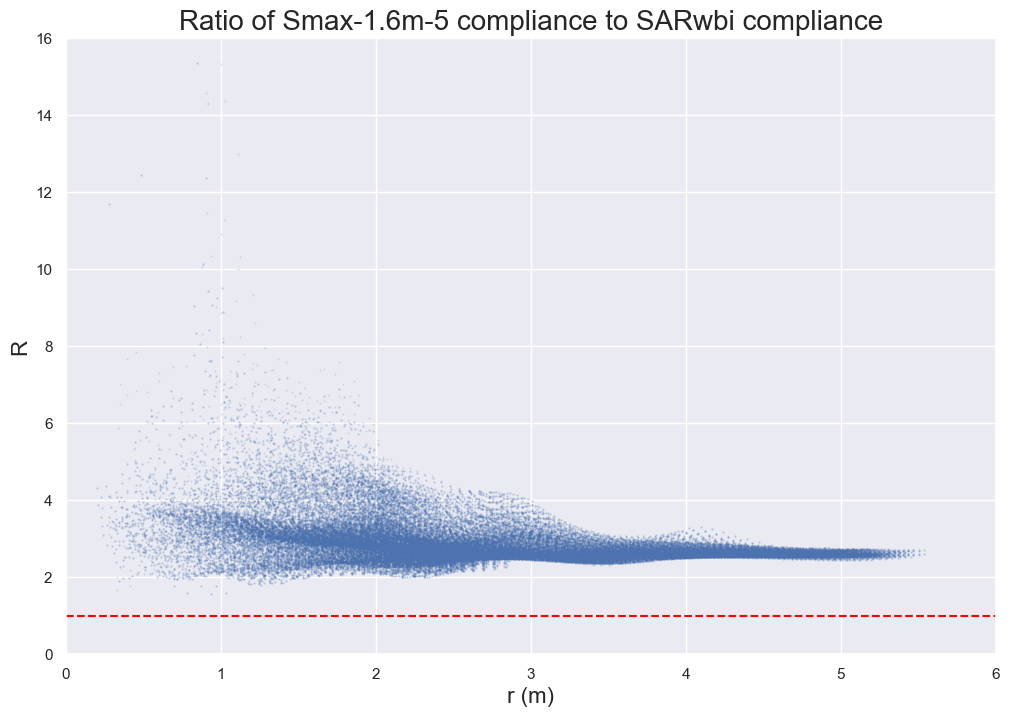

In [45]:
Ssa = 'Smax-1.6m-5 SARwbi compliance ratio'
mask = fsa16.mask
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r2'], y=R.S.loc[mask,Ssa],alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Ssa],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.set_xlim((0,6))
ax.set_ylim((0,16))
ax.set_xticks(range(7))
ax.hlines(1,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'R vs r scatter ({Ssa}) valid 1.6m points yagi.png',dpi=150)

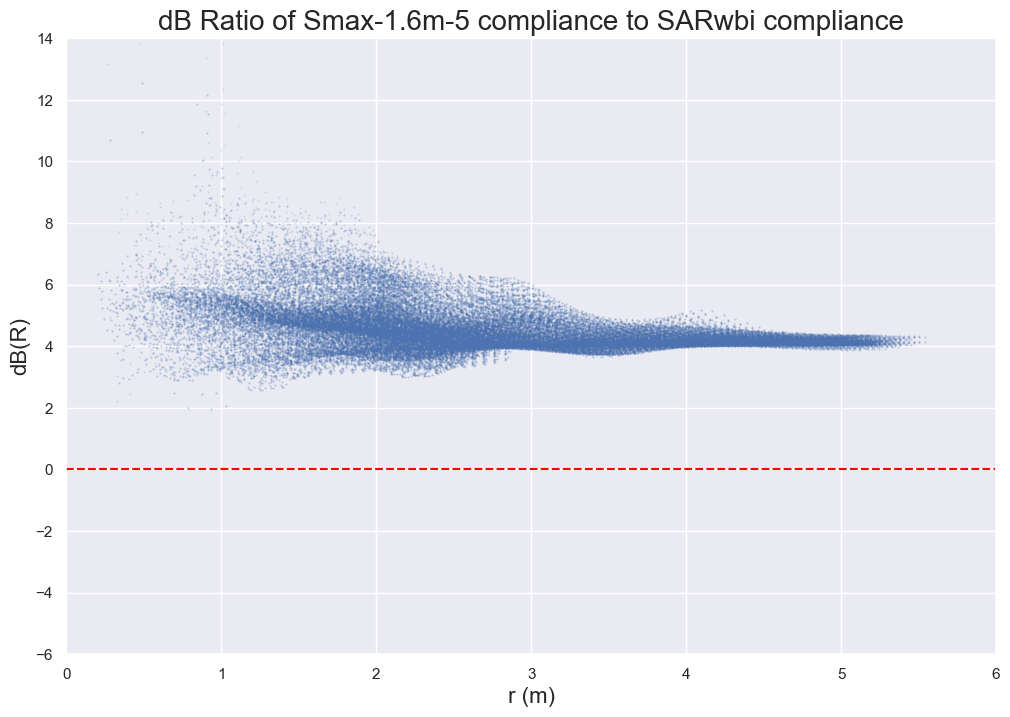

In [46]:
Ssa = 'dB Smax-1.6m-5 SARwbi compliance ratio'
mask = fsa16.mask
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r2'], y=R.S.loc[mask,Ssa],alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Ssa],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('dB(R)', fontsize=16)
ax.set_xlim((0,6))
ax.set_ylim((-6,14))
ax.set_xticks(range(7))
ax.set_yticks(range(-6,15,2))
ax.hlines(0,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'dB(R) vs r scatter ({Ssa}) yagi.png',dpi=150)

In [69]:
Ssa = 'dB Smax-1.6m-5 SARwbi compliance ratio'
f = R.sf('((y==0) | (z==0)) & (y<=0) & (z>=0)')
f.mask = f.mask & fsa16.mask

R.msp(data=Ssa,f=f,mp=1,V=[-6, 6],nlabels=9,ncolors=8, scale=0.1,
      antenna=RFcalcUC.hyagi,ctitle='dB(R)',standard='RPS S-1 WB')

replacing y with S.y --> ((S.y==0) | (z==0)) & (S.y<=0) & (z>=0)
replacing z with S.z --> ((S.y==0) | (S.z==0)) & (S.y<=0) & (S.z>=0)
meval: ((S.y==0) | (S.z==0)) & (S.y<=0) & (S.z>=0)


## Point spatial vs spatial average uncertainty

In [80]:
# Compare SE and SE-1.6m-5
n = 2
R.ExclusionZone(
    data=["SE","SE-1.6m-5"],
    power=[20] * n,
    color=["lightgrey","green"],
    alpha=[0.7, 0.4],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="SE vs SE-1.6m-5 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.hyagi,
)

dat='SE', con=22.5
dat='SE-1.6m-5', con=22.5
power=100, plotpower=20, setting=public, limit=4.5 W/m², contour level=22.500
power=100, plotpower=20, setting=public, limit=4.5 W/m², contour level=22.500


### Create error data column in R.S

In [92]:
# Create error data
err = R.S['SE'] / R.S['SE-1.6m-5']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE v SE-1.6m-5', 'dB error for SE/SE-1.6m-5')

err = R.S['SE'] / R.S['SE-1.6m-17']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE v SE-1.6m-17', 'dB error for SE/SE-1.6m-17')

err = R.S['SE-1.6m-5'] / R.S['SE-1.6m-17']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE-1.6m-5 v SE-1.6m-17', 'dB error for SE-1.6m-5/SE-1.6m-17')

In [99]:
R.S.z.unique()

array([-3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
       -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9,
       -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,
        0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,
        1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,
        2.5,  2.6,  2.7,  2.8,  2.9,  3. ])

### Analyse points close to the antenna (within λ)

replacing z with S.z --> (S.z >= -2.2) & (S.z <= 2.2)
meval: (S.z >= -2.2) & (S.z <= 2.2)


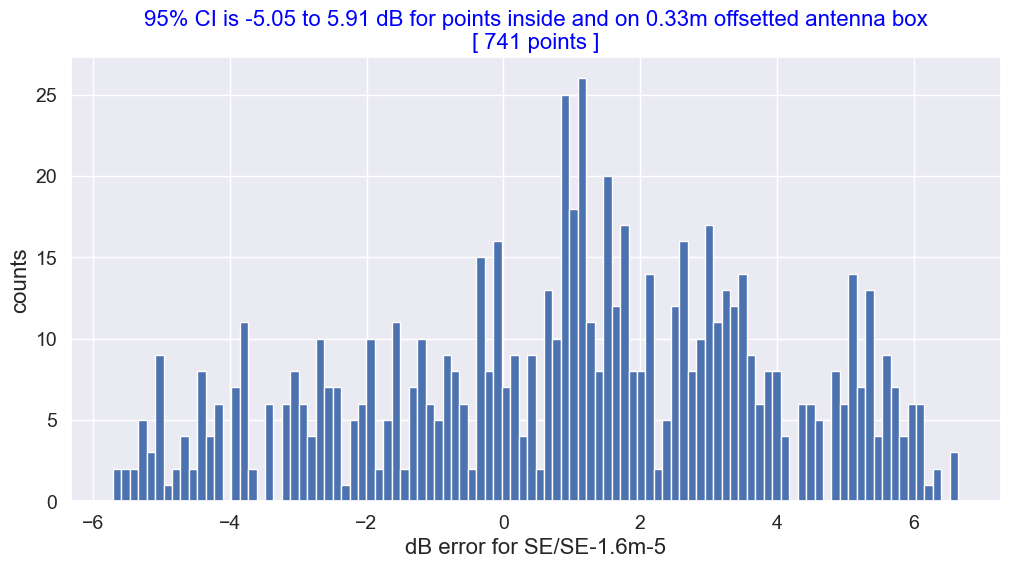

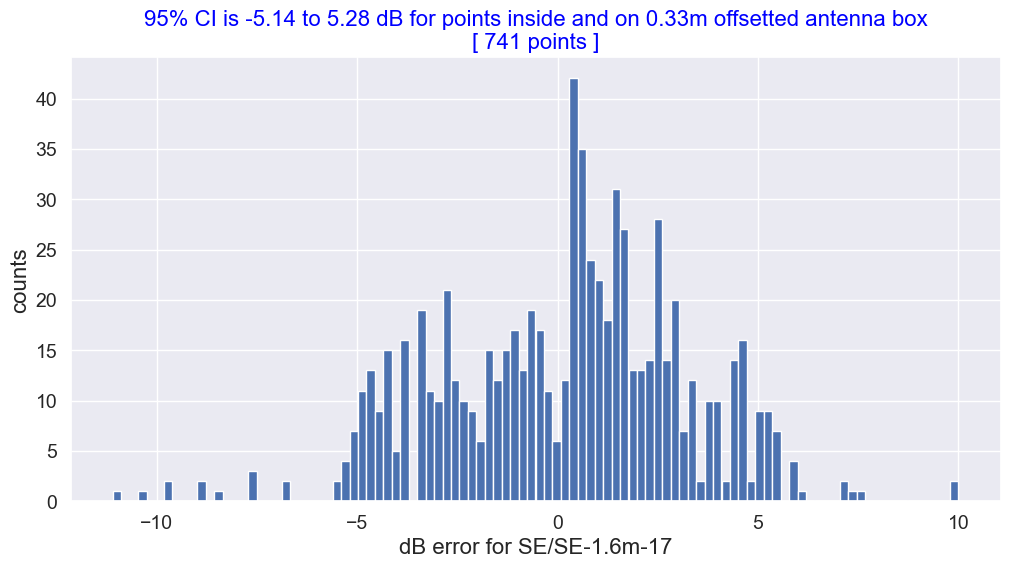

In [102]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f0 = R.sf('(z >= -2.2) & (z <= 2.2)')  # exclude points that aren't properly averaged
f1 = R.sf('ant', offset=d, setting='pub', power=100)
f1.mask = f1.mask & f0.mask

# Show filter points
R.msp(data='dBerr SE v SE-1.6m-5', f=f1, mp=1, V=[-10, 10], nlabels=21, ncolors=8,
      scale=0.025, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

# Show SARwbi histogram
R.hist(data='dBerr SE v SE-1.6m-5', f=f1, CI=95, bins=100)
R.hist(data='dBerr SE v SE-1.6m-17', f=f1, CI=95, bins=100)

### Analyse points *not* close to the antenna (further than λ)

replacing z with S.z --> (S.z >= -2.2) & (S.z <= 2.2)
meval: (S.z >= -2.2) & (S.z <= 2.2)


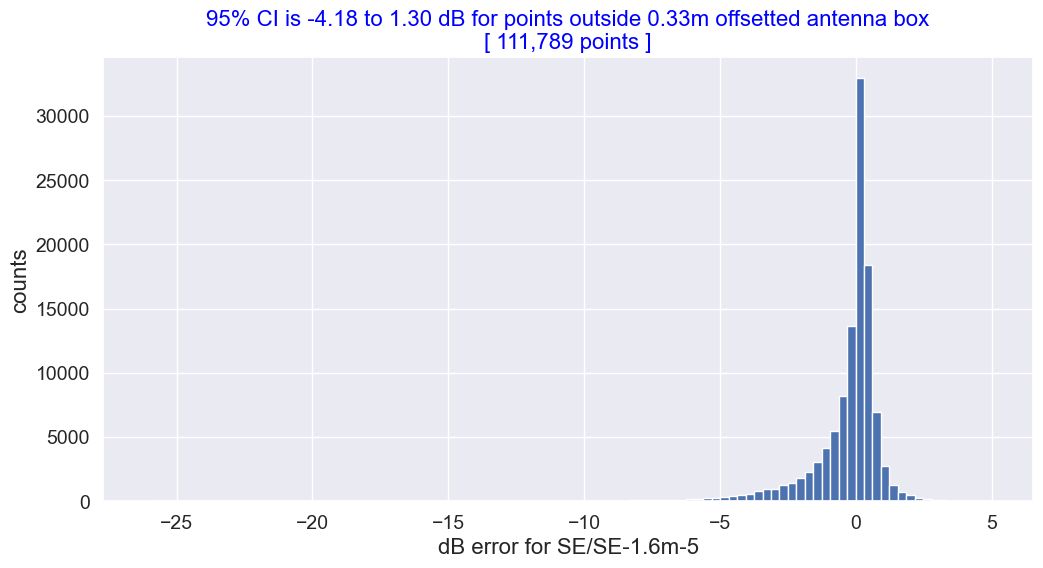

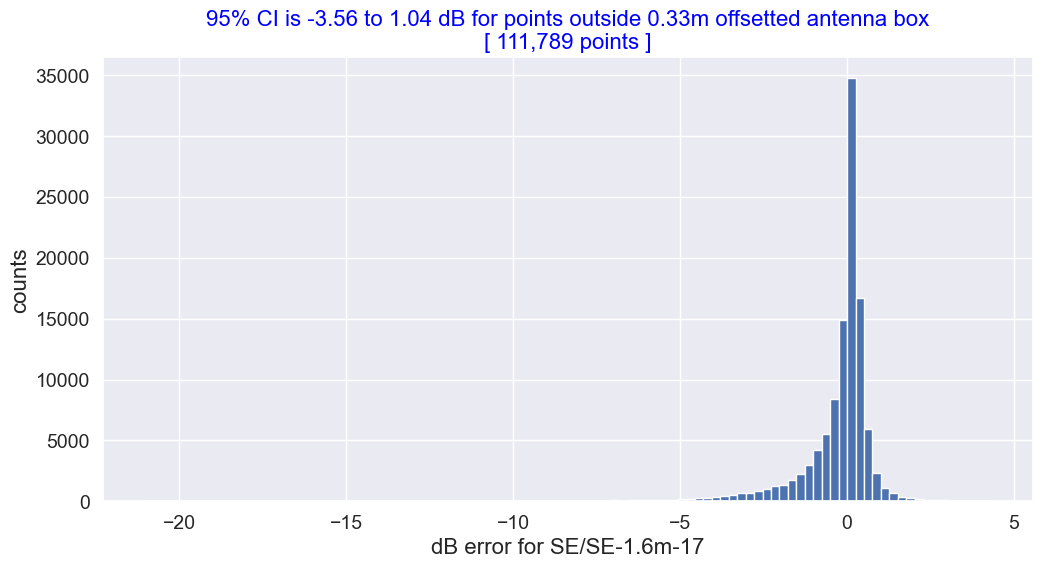

In [105]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f0 = R.sf('(z >= -2.2) & (z <= 2.2)')  # exclude points that aren't properly averaged
f2 = R.sf('outant', offset=d, setting='pub', power=100)
f2.mask = f2.mask & f0.mask

# Show SARwbi histogram
R.hist(data='dBerr SE v SE-1.6m-5', f=f2, CI=95, bins=100)
R.hist(data='dBerr SE v SE-1.6m-17', f=f2, CI=95, bins=100)

# Show filter points
R.msp(data='dBerr SE v SE-1.6m-5', f=f2, mp=4, V=[-10, 10], nlabels=21, ncolors=8,
      scale=0.025, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

### Analyse points *not* close to the antenna (further than λ)

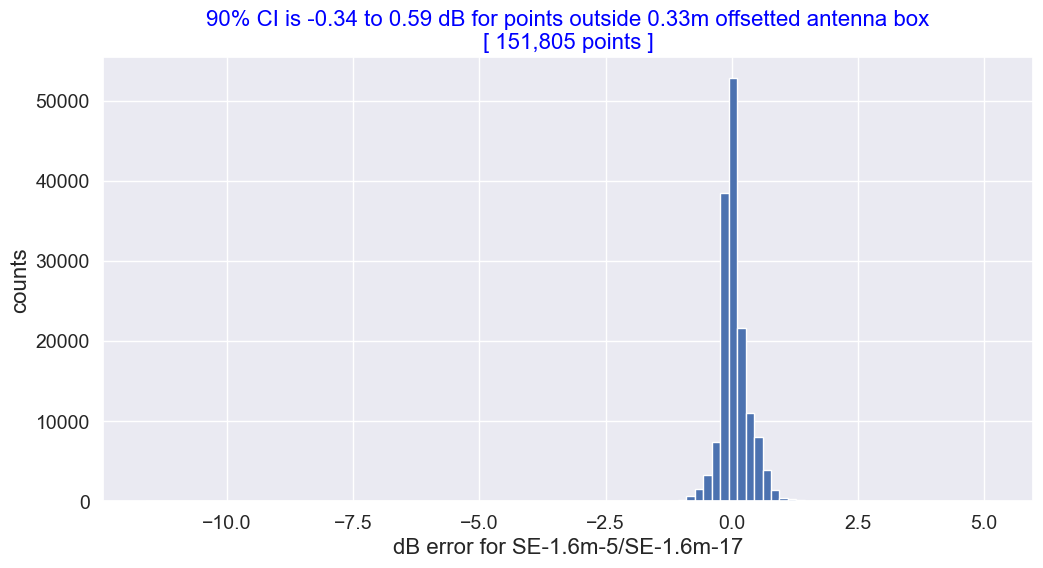

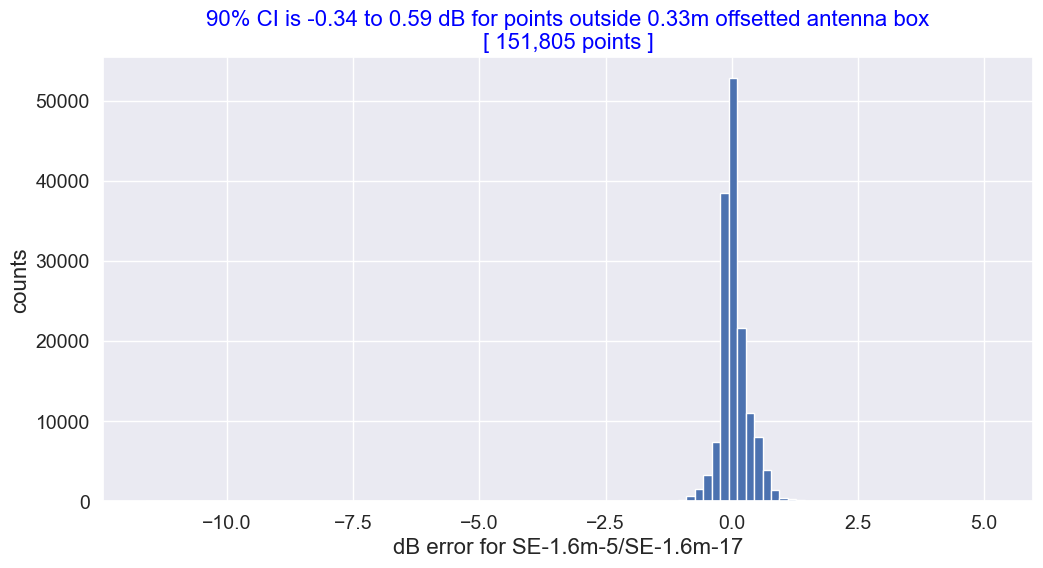

In [96]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f2 = R.sf('outant', offset=d, setting='pub', power=100)

# Show SARwbi histogram
R.hist(data='dBerr SE-1.6m-5 v SE-1.6m-17', f=f2, CI=90, bins=100)
R.hist(data='dBerr SE-1.6m-5 v SE-1.6m-17', f=f2, CI=90, bins=100)

# Show filter points
# R.msp(data='dBerr SE v SE-1.6m-5', f=f2, mp=4, V=[-10, 10], nlabels=21, ncolors=8,
#       scale=0.025, antenna=RFcalcUC.hyagi, ctitle=None, standard='RPS S-1 WB')

In [53]:
R.freq

900

## Scratch

In [104]:
def skewGrid():
    '''Show S and SAR grid points
    usage: .showgrids(S, SAR)
      S = flag to toggle S grid visibility (True/False)
    SAR = flag to toggle SAR grid visibility (True/False)
    hman = height of body model behind antenna in m
           If hman = None, then man model is not displayed
    avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
    '''
    # Make the grid
    x = [-0.8,-0.3,0.2, 0.5, 0.8, 1.3, 2, 3.2, 5, 7.3, 10, 13]
    y = [0, 0.3, 0.8, 1.6, 2.6, 4, 6]
    z = [-2,-1, 0, 1, 2]    
    xx, yy, zz = np.meshgrid(x,y,z)
    
    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(900,900), bgcolor=(0.3, 0.3, 0.3))
    mlab.clf()

    # draw the SAR grid popints
    mlab.points3d(xx,yy,zz,scale_factor=0.1,color=(1,1,0),opacity=1)   # SAR grid

    # Add the antenna box
    RFcalcUC.hyagi('yellow')

    # Draw the scene
    fig.scene.parallel_projection = True
    mlab.show()
    
skewGrid()

In [42]:
a = pd.Series([1,2,3,np.nan])
display(a)
a.mean()

0    1.0
1    2.0
2    3.0
3    NaN
dtype: float64

2.0

KstestResult(statistic=0.02695698665017554, pvalue=0.45373481183512343)

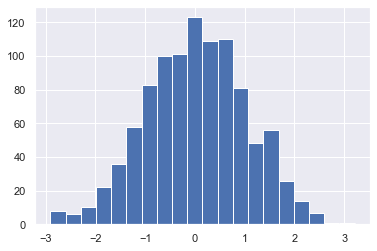

In [263]:
import numpy as np
from scipy import stats
np.random.seed(9)

my_data = stats.norm.rvs(size=1000)
plt.hist(my_data,bins=20);
stats.kstest(my_data, 'norm')

In [22]:
R.S['SARwbi'].dropna().size

689579

### Mayavi animations

In [4]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

In [2]:
import numpy as np
from mayavi import mlab
x, y = np.mgrid[0:3:1,0:3:1]
s = mlab.surf(x, y, np.asarray(x*0.1, 'd'))

@mlab.animate
def anim():
    for i in range(10):
        s.mlab_source.scalars = np.asarray(x*0.1*(i+1), 'd')
        yield

anim()
mlab.show()

In [6]:
# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

# View it.
l = mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')

# Now animate the data.
ms = l.mlab_source
for i in range(10):
    x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer + np.pi*(i+1)/5.)*0.5)
    scalars = np.sin(mu + np.pi*(i+1)/5)
    ms.trait_set(x=x, scalars=scalars)
    
mlab.show()

In [8]:
from mayavi import mlab
@mlab.animate(delay=100, ui=False)
def anim():
    f = mlab.gcf()
    while 1:
        f.scene.camera.azimuth(2)
        f.scene.render()
        yield

a = anim() # Starts the animation.
mlab.show()

In [10]:
import numpy as np
from mayavi import mlab

@mlab.animate(delay = 100)
def updateAnimation():
    t = 0.0
    while True:
        ball.mlab_source.set(x = np.cos(t), y = np.sin(t), z = 0)
        t += 0.1
        yield

ball = mlab.points3d(np.array(1.), np.array(0.), np.array(0.))

updateAnimation()
mlab.show()

In [29]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

@mlab.animate(delay = 50)
def updateAnimation():
    az = 0.0
    while True:
        mlab.view(azimuth=az, elevation=70,distance=10)
        az += 1
        yield

# View it.
fig = mlab.figure(1, size=(900,900), bgcolor=(1,1,1))
mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')
updateAnimation()
mlab.show()

### Fast start

In [8]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# Set trial number
trial = 2
t = trials[str(trial)]

# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [-0.04, 0]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)

# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print()
print(*R.grid.items(),sep='\n')
print()
R.S.info()

datadir = '../antennas/MBSpanel_2/data/'
plotdir = '../antennas/MBSpanel_2/plots/'
Sfile='../antennas/MBSpanel_2/data/MBSpanel_2.hdf5'


,x,y,z,r,phi,SE,SH,Smax,SARwb,SARwbi
0,-1.0,-7.0,-3.0,7.071068,-98.130102,0.007138,0.007219,0.007219,NaN,NaN
1,-1.0,-7.0,-2.9,7.071068,-98.130102,0.007635,0.007725,0.007725,NaN,NaN
2,-1.0,-7.0,-2.8,7.071068,-98.130102,0.007646,0.007729,0.007729,NaN,NaN
3,-1.0,-7.0,-2.7,7.071068,-98.130102,0.007189,0.007244,0.007244,NaN,NaN
4,-1.0,-7.0,-2.6,7.071068,-98.130102,0.006404,0.006415,0.006415,NaN,NaN


{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}


('x', [-1, 14, 0.1])
('y', [-7, 7, 0.1])
('z', [-3, 3, 0.1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298751 entries, 0 to 1298750
Data columns (total 10 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   x       1298751 non-null  float64
 1   y       1298751 non-null  float64
 2   z       1298751 non-null  float64
 3   r       1298751 non-null  float64
 4   phi     1298751 non-null  float64
 5   SE      1298751 non-null  float64
 6   SH      1298751 non-null  float64
 7   Smax    1298751 non-null  float64
 8   SARwb   780 non-null      float64
 9   SARwbi  689579 non-null   float64
dtypes: float64(10)
memory usage: 99.1 MB


In [22]:
# test filter options
fname = 'outant'
fname = 'spatavg_outant'
fname = 'all'
fname = 'ant'
fname = 'cb'
fname = 'icb'

f = R.sf(fname,offset=0.7,spatavgL=1.6)
df = R.S[f.mask]
RFcalcUC.show_grid_points(df, fields=['Smax'],hman=1.6,axv=(True,True,True),
                          antenna=RFcalcUC.panelAntenna,title='')